### Introduction:
Accurately predicting stock prices is a critical task in financial markets, where traditional methods relying on historical trends often fail to capture real-time influences such as public sentiment. Social media platforms like Twitter serve as rich sources of sentiment data, reflecting public opinions that significantly impact market movements.

This project integrates sentiment analysis with financial time series modeling to predict stock prices.Sentiment features,derived from social media analysis,are combined with traditional price and volume data to create a comprehensive feature set.Using advanced machine learning models such as Long Short-Term Memory (LSTM) networks, the research captures both the temporal dependencies in financial data and the influence of public sentiment.


### Datasets used:
- <h4>Dataset used to train the sentiment analysis model:</h4>
  
   Twitter-Financial News Sentiment(<https://huggingface.co/datasets/zeroshot/twitter-financial-news-sentiment/tree/main>)
   - sent_train.csv
   - sent_valid.csv
- <h4>Dataset used to train and test the stock price prediction model:</h4>

  - Nvidia_stock.csv
  - Nvidia_Tweets.csv
  

In [4]:
'''
! pip install transformers 
! pip install datasets
! pip install torch
'''

'\n! pip install transformers \n! pip install datasets\n! pip install torch\n'

### Sentiment Analysis

In [5]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [6]:
import pandas as pd
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification,Trainer,TrainingArguments


In [7]:
train_df = pd.read_csv('sent_train.csv')
val_df = pd.read_csv('sent_valid.csv')

In [8]:
print(train_df.head())
print(val_df.head())

                                                text  label
0  $BYND - JPMorgan reels in expectations on Beyo...      0
1  $CCL $RCL - Nomura points to bookings weakness...      0
2  $CX - Cemex cut at Credit Suisse, J.P. Morgan ...      0
3  $ESS: BTIG Research cuts to Neutral https://t....      0
4  $FNKO - Funko slides after Piper Jaffray PT cu...      0
                                                text  label
0  $ALLY - Ally Financial pulls outlook https://t...      0
1  $DELL $HPE - Dell, HPE targets trimmed on comp...      0
2  $PRTY - Moody's turns negative on Party City h...      0
3                   $SAN: Deutsche Bank cuts to Hold      0
4                  $SITC: Compass Point cuts to Sell      0


In [9]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis")
def tokenize_data(df):
    return tokenizer(
        df['text'].tolist(),
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

train_encodings = tokenize_data(train_df)
val_encodings = tokenize_data(val_df)


In [10]:
# 将编码和标签打包成Dataset对象
import torch
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self,encodings,labels):
        self.encodings=encodings
        self.labels=labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self,idx):
        item = {key: torch.tensor(val[idx]) for key,val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = SentimentDataset(train_encodings,train_df['label'].values)
val_dataset = SentimentDataset(val_encodings,val_df['label'].values)


### Fine-tuning pre-trained models

- <h4>Model: FinancialBERT-Sentiment-Analysis</h4>

In [11]:
from torch.optim import Adam
# Model Training
# Load Pre-Trained model
model = AutoModelForSequenceClassification.from_pretrained(
    "ahmedrachid/FinancialBERT-Sentiment-Analysis",
    num_labels=3
)

# set parameters
training_args = TrainingArguments(
    output_dir="./results",          # 输出目录
    evaluation_strategy="epoch",     # 每个epoch后评估
    learning_rate=2e-05,             # 学习率
    per_device_train_batch_size=16,  # 训练批次大小
    per_device_eval_batch_size=16,   # 验证批次大小
    num_train_epochs=2,              # 训练周期
    weight_decay=0.01,
    
)

# Define Adam optimizer
optimizer = Adam(
    model.parameters(),
    lr=2e-5,
    betas=(0.9,0.999),
    eps = 1e-08
)

# Use Trainer
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    optimizers=(optimizer,None)
)

trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/1194 [00:00<?, ?it/s]

{'loss': 0.6269, 'grad_norm': 9.523309707641602, 'learning_rate': 1.1624790619765495e-05, 'epoch': 0.84}


  0%|          | 0/150 [00:00<?, ?it/s]

{'eval_loss': 0.45877090096473694, 'eval_runtime': 21.188, 'eval_samples_per_second': 112.705, 'eval_steps_per_second': 7.079, 'epoch': 1.0}
{'loss': 0.396, 'grad_norm': 10.595842361450195, 'learning_rate': 3.2495812395309884e-06, 'epoch': 1.68}


  0%|          | 0/150 [00:00<?, ?it/s]

{'eval_loss': 0.4469180107116699, 'eval_runtime': 20.8572, 'eval_samples_per_second': 114.493, 'eval_steps_per_second': 7.192, 'epoch': 2.0}
{'train_runtime': 607.9256, 'train_samples_per_second': 31.395, 'train_steps_per_second': 1.964, 'train_loss': 0.48198977906500273, 'epoch': 2.0}


TrainOutput(global_step=1194, training_loss=0.48198977906500273, metrics={'train_runtime': 607.9256, 'train_samples_per_second': 31.395, 'train_steps_per_second': 1.964, 'total_flos': 1255445672689152.0, 'train_loss': 0.48198977906500273, 'epoch': 2.0})

In [12]:
eval_results = trainer.evaluate(eval_dataset=val_dataset)

  0%|          | 0/150 [00:00<?, ?it/s]

In [13]:
print(eval_results)

{'eval_loss': 0.4469180107116699, 'eval_runtime': 20.8279, 'eval_samples_per_second': 114.654, 'eval_steps_per_second': 7.202, 'epoch': 2.0}


In [14]:
# Generate prediction
predictions_output = trainer.predict(val_dataset)
predictions = predictions_output.predictions
labels = predictions_output.label_ids

  0%|          | 0/150 [00:00<?, ?it/s]

In [15]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Get predicted labels
predicted_labels = predictions.argmax(axis=-1)

# Compute metrics
accuracy = accuracy_score(labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(labels, predicted_labels, average="weighted")

# Print metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")


Accuracy: 0.8417085427135679
Precision: 0.8387346756995538
Recall: 0.8417085427135679
F1-Score: 0.8396243382571247


- <h4> Model: distilroberta-finetuned-financial-news-sentiment-analysis</h4>

In [16]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
def tokenize_data(df):
    return tokenizer(
        df['text'].tolist(),
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

train_encodings = tokenize_data(train_df)
val_encodings = tokenize_data(val_df)


In [17]:
# 将编码和标签打包成Dataset对象
import torch
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self,encodings,labels):
        self.encodings=encodings
        self.labels=labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self,idx):
        item = {key: torch.tensor(val[idx]) for key,val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = SentimentDataset(train_encodings,train_df['label'].values)
val_dataset = SentimentDataset(val_encodings,val_df['label'].values)


In [179]:
from torch.optim import Adam
# Model Training
# Load Pre-Trained model
model = AutoModelForSequenceClassification.from_pretrained(
    "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis",
    num_labels=3
)

# set parameters
training_args = TrainingArguments(
    output_dir="./results",          # 输出目录
    evaluation_strategy="epoch",     # 每个epoch后评估
    learning_rate=2e-05, # 学习率
    lr_scheduler_type="linear",
    per_device_train_batch_size=8,  # 训练批次大小
    per_device_eval_batch_size=8,   # 验证批次大小
    num_train_epochs=1,              # 训练周期
    seed = 42,
)

# Define Adam optimizer
optimizer = Adam(
    model.parameters(),
    lr=2e-5,
    betas=(0.9,0.999),
    eps = 1e-08
)

# Use Trainer
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    optimizers=(optimizer,None)
)

trainer.train()

  0%|          | 0/1193 [00:00<?, ?it/s]

{'loss': 0.654, 'grad_norm': 10.426925659179688, 'learning_rate': 1.1617770326906959e-05, 'epoch': 0.42}
{'loss': 0.4414, 'grad_norm': 25.38789939880371, 'learning_rate': 3.235540653813915e-06, 'epoch': 0.84}


  0%|          | 0/299 [00:00<?, ?it/s]

{'eval_loss': 0.34869149327278137, 'eval_runtime': 11.1041, 'eval_samples_per_second': 215.056, 'eval_steps_per_second': 26.927, 'epoch': 1.0}
{'train_runtime': 203.2055, 'train_samples_per_second': 46.962, 'train_steps_per_second': 5.871, 'train_loss': 0.5295186710277727, 'epoch': 1.0}


TrainOutput(global_step=1193, training_loss=0.5295186710277727, metrics={'train_runtime': 203.2055, 'train_samples_per_second': 46.962, 'train_steps_per_second': 5.871, 'total_flos': 316039732363008.0, 'train_loss': 0.5295186710277727, 'epoch': 1.0})

In [181]:
# 比较训练前后模型参数是否相同
from transformers import AutoModelForSequenceClassification
import torch

# 加载训练前的模型
model_pretrained = AutoModelForSequenceClassification.from_pretrained(
    "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis",
    num_labels=3
)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model_pretrained.to(device)
model.to(device)
# 比较权重
parameters_are_equal = all(
    torch.equal(param1, param2) 
    for param1, param2 in zip(model_pretrained.parameters(), model.parameters())
)

print("模型参数是否相同:", parameters_are_equal)


模型参数是否相同: False


#### 模型训练成功！

In [19]:
eval_results = trainer.evaluate(eval_dataset=val_dataset)
print(eval_results)


  0%|          | 0/299 [00:00<?, ?it/s]

{'eval_loss': 0.3486916124820709, 'eval_runtime': 11.0653, 'eval_samples_per_second': 215.81, 'eval_steps_per_second': 27.021, 'epoch': 1.0}


In [20]:
# Generate prediction
predictions_output = trainer.predict(val_dataset)
predictions = predictions_output.predictions
labels = predictions_output.label_ids
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Get predicted labels
predicted_labels = predictions.argmax(axis=-1)

# Compute metrics
accuracy = accuracy_score(labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(labels, predicted_labels, average="weighted")

# Print metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")


  0%|          | 0/299 [00:00<?, ?it/s]

Accuracy: 0.8664154103852596
Precision: 0.8687440464485905
Recall: 0.8664154103852596
F1-Score: 0.8672058523930589


#### Model Comparison:
- FinancialBERT-Sentiment-Analysis:
  
  Accuracy: 0.8417085427135679

  Precision: 0.8387346756995538

  Recall: 0.8417085427135679

  F1-Score: 0.8396243382571247
- distilroberta-finetuned-financial-news-sentiment-analysis:

  Accuracy: 0.8664154103852596

  Precision: 0.8687440464485905

  Recall: 0.8664154103852596

  F1-Score: 0.8672058523930589
<h4>The"distilroberta-finetuned-financial-news-sentiment-analysis" model performs better </h4>

### Save the model

In [21]:
model.save_pretrained("./fine_tuned_model")
tokenizer.save_pretrained("./fine_tuned_model")

('./fine_tuned_model/tokenizer_config.json',
 './fine_tuned_model/special_tokens_map.json',
 './fine_tuned_model/vocab.json',
 './fine_tuned_model/merges.txt',
 './fine_tuned_model/added_tokens.json',
 './fine_tuned_model/tokenizer.json')

### Nvidia Sentiment Analysis

In [22]:
# Load Nvidia-Tweets.csv
data_nt = pd.read_csv('Processed_Nvidia_Tweets.csv')
data_nt.head()

,Unnamed: 0,Datetime,Tweet Id,Text,Username
0,99665,2022-11-21,1.594759e+18,Trending: Semiconductor\n\n$NVDA -0.60 %\n$INT...,FrenzyCapital
1,99917,2022-11-21,1.594714e+18,$NVDA - Above 263 - Trade Idea 💡 - April 8 27...,anita37992698
2,99851,2022-11-21,1.594727e+18,$NVDA some red to green strength while Semis a...,OptionsHawk
3,99700,2022-11-21,1.594753e+18,The POWER of DCA (Dollar Cost https://t.co/TKF...,SusanSouth13
4,99603,2022-11-21,1.594766e+18,🔥Most active Trading Group 💯 \nhttps://t.co/Mm...,skitontop1


In [23]:
data_nt =  data_nt.drop(columns=['Unnamed: 0','Tweet Id','Username'],errors = 'ignore')

In [24]:
data_nt.head()

,Datetime,Text
0,2022-11-21,Trending: Semiconductor\n\n$NVDA -0.60 %\n$INT...
1,2022-11-21,$NVDA - Above 263 - Trade Idea 💡 - April 8 27...
2,2022-11-21,$NVDA some red to green strength while Semis a...
3,2022-11-21,The POWER of DCA (Dollar Cost https://t.co/TKF...
4,2022-11-21,🔥Most active Trading Group 💯 \nhttps://t.co/Mm...


In [25]:
import re
def remove_emojis(text):
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F700-\U0001F77F"  # alchemical symbols
        "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001FA00-\U0001FA6F"  # Chess Symbols
        "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        "\U00002702-\U000027B0"  # Dingbats
        "\U000024C2-\U0001F251" 
        "]", 
        flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)


In [26]:
data_nt['Text']=data_nt['Text'].apply(remove_emojis)
data_nt.head()

,Datetime,Text
0,2022-11-21,Trending: Semiconductor\n\n$NVDA -0.60 %\n$INT...
1,2022-11-21,$NVDA - Above 263 - Trade Idea - April 8 272...
2,2022-11-21,$NVDA some red to green strength while Semis a...
3,2022-11-21,The POWER of DCA (Dollar Cost https://t.co/TKF...
4,2022-11-21,Most active Trading Group \nhttps://t.co/MmIM...


In [27]:
from transformers import pipeline
from concurrent.futures import ThreadPoolExecutor
model_path="./fine_tuned_model"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)
sentiment_classifier = pipeline("text-classification",model=model,tokenizer=tokenizer,return_all_scores=True,device=-1)

label_mapping = {'negative':-1,'neutral':0,'positive':1}

def batch_predict_sentiment(texts):
    predictions = sentiment_classifier(texts)
    results = []
    for prediction in predictions:
        max_label = max(prediction,key=lambda x: x['score']) #获取概率最大的标签
        label_id = label_mapping[max_label['label']]
        results.append((label_id,max_label['score']))
    return results


# 使用ThreadPoolExecutor进行并行预测
def parallel_predict(data, batch_size=32, num_workers=4):
    sentiments = []
    confidences = []
    
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = []
        
        # 将数据拆分成多个批次并行处理
        for i in range(0, len(data), batch_size):
            batch_texts = data['Text'][i:i + batch_size].tolist()
            futures.append(executor.submit(batch_predict_sentiment, batch_texts))
        
        # 等待所有批次的预测结果
        for future in futures:
            batch_results = future.result()
            sentiments.extend([res[0] for res in batch_results])
            confidences.extend([res[1] for res in batch_results])
    
    return sentiments, confidences


# 进行并行预测
sentiments, confidences = parallel_predict(data_nt, batch_size=32, num_workers=4)


data_nt['Sentiment'] = sentiments
data_nt['Confidence'] = confidences


Device set to use cpu


In [28]:
data_nt.head()


,Datetime,Text,Sentiment,Confidence
0,2022-11-21,Trending: Semiconductor\n\n$NVDA -0.60 %\n$INT...,-1,0.956855
1,2022-11-21,$NVDA - Above 263 - Trade Idea - April 8 272...,0,0.844328
2,2022-11-21,$NVDA some red to green strength while Semis a...,0,0.554483
3,2022-11-21,The POWER of DCA (Dollar Cost https://t.co/TKF...,1,0.969959
4,2022-11-21,Most active Trading Group \nhttps://t.co/MmIM...,1,0.987370


In [29]:
data_nt['Datetime']=pd.to_datetime(data_nt['Datetime']).dt.date # make sure datetime is datetime type
# weighted sentiment
daily_sentiment = (
    data_nt
    .groupby('Datetime')
    .apply(lambda x: (x['Sentiment']*x['Confidence']).sum()/x['Confidence'].sum())
    .reset_index(name='Daily_Sentiment')
)



/var/folders/y9/rm6ywzws5czgbzjyb7d2cny00000gn/T/ipykernel_2922/556639491.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x['Sentiment']*x['Confidence']).sum()/x['Confidence'].sum())


In [30]:
data_s = daily_sentiment

In [31]:
data_s

,Datetime,Daily_Sentiment
0,2022-11-21,0.547059
1,2022-11-22,0.554893
2,2022-11-23,0.580595
3,2022-11-24,0.680213
4,2022-11-25,0.631039
...,...,...
73,2023-02-02,0.629935
74,2023-02-03,0.619572
75,2023-02-04,0.588633
76,2023-02-05,0.668878


### Stock Prediction：
- The Trend
- The accurate price

#### Import Nvidia_stock.csv

In [32]:
data_ns = pd.read_csv('Nvidia_stock.csv')
data_ns

,Date,Open,High,Low,Close,Volume
0,NaN,NVDA,NVDA,NVDA,NVDA,NVDA
1,2022-11-21,15.132120243655514,15.461795982930148,15.0651856742172,15.301953315734863,404739000
2,2022-11-22,15.312941004415727,16.042224307977705,15.107143062322645,16.02224349975586,472866000
3,2022-11-23,16.082185426693993,16.51076484483677,16.032235307241766,16.502771377563477,427241000
4,2022-11-25,16.301971969557428,16.47080468398519,16.156115473704112,16.254018783569336,167934000
5,2022-11-28,16.01025486285479,16.34093096346319,15.709551881196315,15.811450958251953,303741000
6,2022-11-29,15.811450315725434,15.916347653150785,15.50475272274018,15.623635292053223,298384000
7,2022-11-30,15.68559017782251,16.917694725911424,15.58566343466165,16.91069984436035,565298000
8,2022-12-01,16.986644417378525,17.25244991006303,16.622908679321707,17.12254524230957,470977000
9,2022-12-02,16.646891961361217,16.92069297480223,16.43304680382368,16.863733291625977,371389000


#### Merge the Sentiment Features and Volume&Price Features

In [33]:
data_ns = data_ns.rename(columns={'Date':'Datetime'})


In [34]:
data_s['Datetime'] = pd.to_datetime(data_s['Datetime']).dt.date
data_ns['Datetime'] = pd.to_datetime(data_ns['Datetime']).dt.date
merged_data = pd.merge(data_ns,data_s,on='Datetime',how='left')


In [35]:
merged_data.head()

,Datetime,Open,High,Low,Close,Volume,Daily_Sentiment
0,NaT,NVDA,NVDA,NVDA,NVDA,NVDA,NaN
1,2022-11-21,15.132120243655514,15.461795982930148,15.0651856742172,15.301953315734863,404739000,0.547059
2,2022-11-22,15.312941004415727,16.042224307977705,15.107143062322645,16.02224349975586,472866000,0.554893
3,2022-11-23,16.082185426693993,16.51076484483677,16.032235307241766,16.502771377563477,427241000,0.580595
4,2022-11-25,16.301971969557428,16.47080468398519,16.156115473704112,16.254018783569336,167934000,0.631039


In [170]:
data = merged_data.drop(index=0).reset_index(drop=True)
data.head()

,Datetime,Open,High,Low,Close,Volume,Daily_Sentiment
0,2022-11-21,15.132120243655514,15.461795982930148,15.0651856742172,15.301953315734863,404739000,0.547059
1,2022-11-22,15.312941004415727,16.042224307977705,15.107143062322645,16.02224349975586,472866000,0.554893
2,2022-11-23,16.082185426693993,16.51076484483677,16.032235307241766,16.502771377563477,427241000,0.580595
3,2022-11-25,16.301971969557428,16.47080468398519,16.156115473704112,16.254018783569336,167934000,0.631039
4,2022-11-28,16.01025486285479,16.34093096346319,15.709551881196315,15.811450958251953,303741000,0.617977


In [37]:
data.to_csv('Prediction_data.csv')

#### To predict the trend

In [176]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [174]:
# Transfer all columns into numeric value
columns = ['Open','High','Low','Close','Volume']
# Convert non-numeric columns
for col in columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')

In [175]:
# create trend labels
data['Trend']= np.where(data['Close'].diff()>0,1,0) # {1:up,0:down or no change}
features = ['Open','High','Low','Volume','Daily_Sentiment']
X = data[features]
y = data['Trend']

# Train-test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,shuffle=False)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [177]:
## Step 2: Model Training and Evaluation
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Support Vector Machine": SVC(random_state=42, kernel='linear', probability=True),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Boosted Tree (XGBoost)": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# Evaluate each model
for name, model in models.items():
    print(f"--- {name} ---")
    
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Predict
    y_pred = model.predict(X_test_scaled)
    
    # Classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\n")


--- Logistic Regression ---
Classification Report:
              precision    recall  f1-score   support

           0       0.25      1.00      0.40         2
           1       1.00      0.33      0.50         9

    accuracy                           0.45        11
   macro avg       0.62      0.67      0.45        11
weighted avg       0.86      0.45      0.48        11

Confusion Matrix:
[[2 0]
 [6 3]]


--- Support Vector Machine ---
Classification Report:
              precision    recall  f1-score   support

           0       0.25      1.00      0.40         2
           1       1.00      0.33      0.50         9

    accuracy                           0.45        11
   macro avg       0.62      0.67      0.45        11
weighted avg       0.86      0.45      0.48        11

Confusion Matrix:
[[2 0]
 [6 3]]


--- Decision Tree ---
Classification Report:
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         2
           1     

#### To predict the accurate price
- Features : data
- Model : LSTM

In [136]:
! pip install tensorflow

In [137]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

#### & Predict "Open"

In [252]:
features = ['Close','High','Low','Volume','Daily_Sentiment']
target = 'Open'
X = data[features].values
y = data[target].values

scaler_X = MinMaxScaler(feature_range=(0,1))
scaler_y = MinMaxScaler(feature_range=(0,1))

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1,1))


In [253]:
# create LSTM Input
sequence_length = 2
X_lstm = []
y_lstm = []
for i in range(sequence_length,len(X_scaled)):
    X_lstm.append(X_scaled[i-sequence_length:i])# 最近2天的特征
    y_lstm.append(y_scaled[i])# 第i天的目标值

X_lstm,y_lstm = np.array(X_lstm),np.array(y_lstm)

train_size = int(len(X_lstm)*0.8)
X_train, X_test = X_lstm[:train_size],X_lstm[train_size:]
y_train,y_test = y_lstm[:train_size],y_lstm[train_size:]

In [254]:
# Build model
model = Sequential()
model.add(LSTM(units=20,return_sequences=False,input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_absolute_error')
model.fit(X_train,y_train,epochs=40,batch_size=8)


Epoch 1/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3388  
Epoch 2/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3122
Epoch 3/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2867
Epoch 4/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2283
Epoch 5/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2055
Epoch 6/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1495
Epoch 7/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1303
Epoch 8/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1079
Epoch 9/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1373
Epoch 10/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1162
Epoch 11/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1317
Epoch 12/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1207 
Epoch 13/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1251 
Epoch 14/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1357 
Epoch 15/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1118 
Epoch 16/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


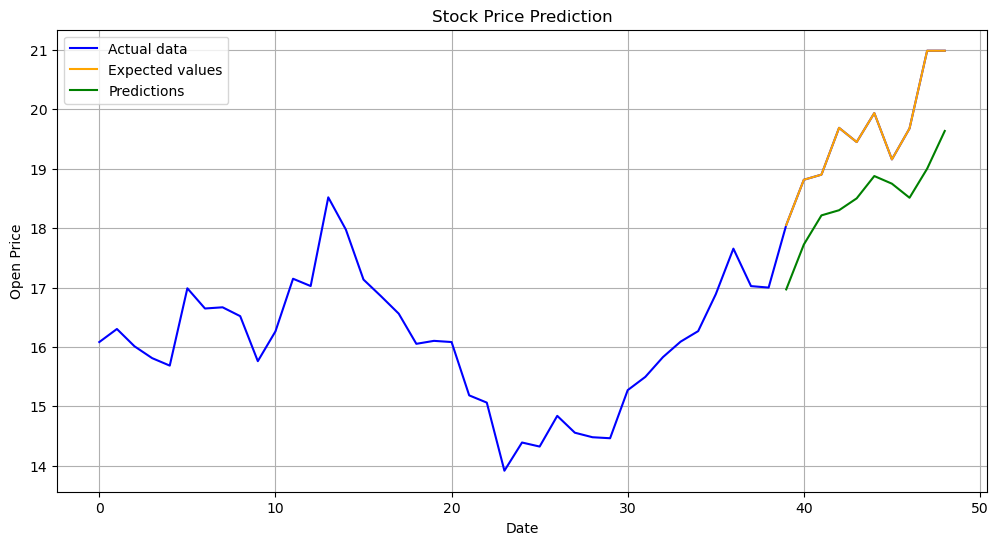

In [255]:
import matplotlib.pyplot as plt
# 训练集的实际值（Trained data）
y_train_actual = scaler_y.inverse_transform(y_train)  # 将训练集反归一化
y_test_actual = scaler_y.inverse_transform(y_test)  # 将测试集反归一化
y_pred = scaler_y.inverse_transform(model.predict(X_test))  # 测试集预测值反归一化


y_actual_combined = np.concatenate([y_train_actual, y_test_actual])
# 创建图表
plt.figure(figsize=(12, 6))

# 绘制训练集的实际值（蓝色）
plt.plot(
    range(len(y_actual_combined)),
    y_actual_combined,
    label='Actual data',
    color='blue'
)

# 绘制测试集的实际值（黄色），保持曲线连续
plt.plot(
    range(len(y_train_actual), len(y_actual_combined)),
    y_test_actual,
    label='Expected values',
    color='orange'
)

# 绘制测试集预测值（绿色）
plt.plot(
    range(len(y_train_actual), len(y_actual_combined)),
    y_pred,
    label='Predictions',
    color='green'
)

# 图表设置
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend()
plt.grid()
plt.show()


In [256]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test_actual, y_pred)
mse = mean_squared_error(y_test_actual, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test_actual, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 1.1161716430253203
Mean Squared Error (MSE): 1.406345569293217
Root Mean Squared Error (RMSE): 1.1858944174306654
R-squared (R²): -0.8317476464354643


#### & Predict "Close"

In [217]:
features = ['Open','High','Low','Volume','Daily_Sentiment']
target = 'Close'
X = data[features].values
y = data[target].values

scaler_X = MinMaxScaler(feature_range=(0,1))
scaler_y = MinMaxScaler(feature_range=(0,1))

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1,1))


In [218]:
# create LSTM Input
sequence_length = 2
X_lstm = []
y_lstm = []
for i in range(sequence_length,len(X_scaled)):
    X_lstm.append(X_scaled[i-sequence_length:i])# 最近2天的特征
    y_lstm.append(y_scaled[i])# 第i天的目标值

X_lstm,y_lstm = np.array(X_lstm),np.array(y_lstm)

train_size = int(len(X_lstm)*0.8)
X_train, X_test = X_lstm[:train_size],X_lstm[train_size:]
y_train,y_test = y_lstm[:train_size],y_lstm[train_size:]

In [219]:
# Build model
model = Sequential()
model.add(LSTM(units=20,return_sequences=False,input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_absolute_error')
model.fit(X_train,y_train,epochs=40,batch_size=8)


Epoch 1/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2811  
Epoch 2/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2393
Epoch 3/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2013
Epoch 4/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1859
Epoch 5/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1275
Epoch 6/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1131
Epoch 7/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1164
Epoch 8/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1020
Epoch 9/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1322
Epoch 10/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1275
Epoch 11/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1185
Epoch 12/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1219
Epoch 13/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1047
Epoch 14/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1119
Epoch 15/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1021
Epoch 16/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/ste

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


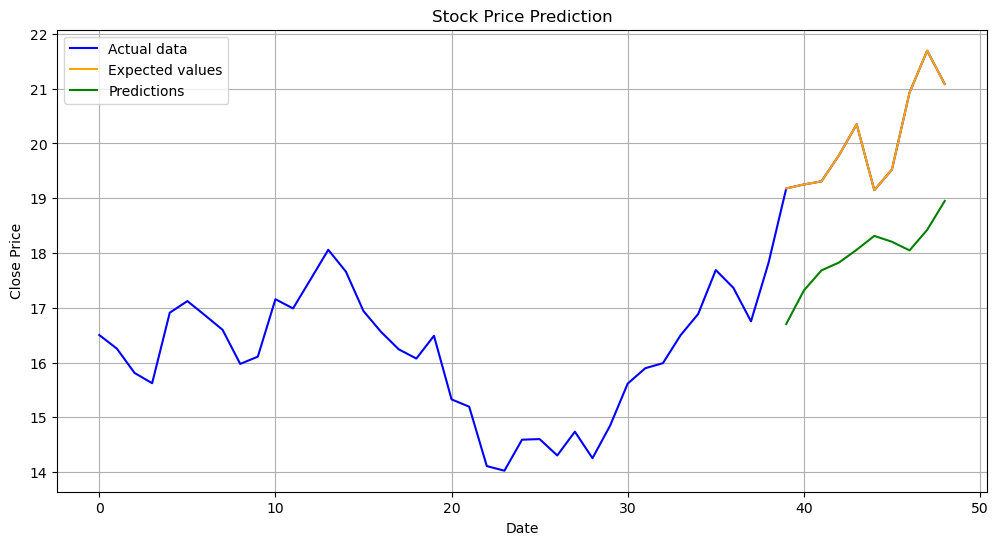

In [220]:
import matplotlib.pyplot as plt
# 训练集的实际值（Trained data）
y_train_actual = scaler_y.inverse_transform(y_train)  # 将训练集反归一化
y_test_actual = scaler_y.inverse_transform(y_test)  # 将测试集反归一化
y_pred = scaler_y.inverse_transform(model.predict(X_test))  # 测试集预测值反归一化


y_actual_combined = np.concatenate([y_train_actual, y_test_actual])
# 创建图表
plt.figure(figsize=(12, 6))

# 绘制训练集的实际值（蓝色）
plt.plot(
    range(len(y_actual_combined)),
    y_actual_combined,
    label='Actual data',
    color='blue'
)

# 绘制测试集的实际值（黄色），保持曲线连续
plt.plot(
    range(len(y_train_actual), len(y_actual_combined)),
    y_test_actual,
    label='Expected values',
    color='orange'
)

# 绘制测试集预测值（绿色）
plt.plot(
    range(len(y_train_actual), len(y_actual_combined)),
    y_pred,
    label='Predictions',
    color='green'
)

# 图表设置
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid()
plt.show()


In [221]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test_actual, y_pred)
mse = mean_squared_error(y_test_actual, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test_actual, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 2.0722837448120117
Mean Squared Error (MSE): 4.757629297020683
Root Mean Squared Error (RMSE): 2.181199050297951
R-squared (R²): -5.153491597387478


#### & Predict "High"

In [247]:
features = ['Open','Low','Close','Volume','Daily_Sentiment']
target = 'High'
X = data[features].values
y = data[target].values

scaler_X = MinMaxScaler(feature_range=(0,1))
scaler_y = MinMaxScaler(feature_range=(0,1))

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1,1))


In [248]:
# create LSTM Input
sequence_length = 2
X_lstm = []
y_lstm = []
for i in range(sequence_length,len(X_scaled)):
    X_lstm.append(X_scaled[i-sequence_length:i])# 最近2天的特征
    y_lstm.append(y_scaled[i])# 第i天的目标值

X_lstm,y_lstm = np.array(X_lstm),np.array(y_lstm)

train_size = int(len(X_lstm)*0.8)
X_train, X_test = X_lstm[:train_size],X_lstm[train_size:]
y_train,y_test = y_lstm[:train_size],y_lstm[train_size:]

In [249]:
# Build model
model = Sequential()
model.add(LSTM(units=20,return_sequences=False,input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_absolute_error')
model.fit(X_train,y_train,epochs=40,batch_size=8)


Epoch 1/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2987  
Epoch 2/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2748
Epoch 3/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2469
Epoch 4/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1868
Epoch 5/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1822
Epoch 6/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1359
Epoch 7/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1474
Epoch 8/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1174
Epoch 9/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1069
Epoch 10/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1212
Epoch 11/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1129
Epoch 12/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0974
Epoch 13/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0978
Epoch 14/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1067
Epoch 15/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0929
Epoch 16/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/ste

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


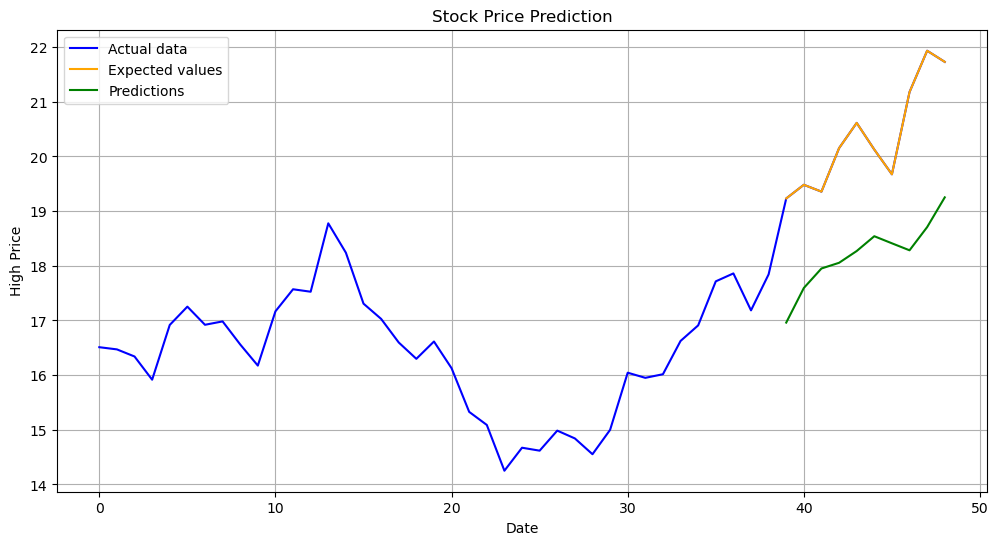

In [250]:
import matplotlib.pyplot as plt
# 训练集的实际值（Trained data）
y_train_actual = scaler_y.inverse_transform(y_train)  # 将训练集反归一化
y_test_actual = scaler_y.inverse_transform(y_test)  # 将测试集反归一化
y_pred = scaler_y.inverse_transform(model.predict(X_test))  # 测试集预测值反归一化


y_actual_combined = np.concatenate([y_train_actual, y_test_actual])
# 创建图表
plt.figure(figsize=(12, 6))

# 绘制训练集的实际值（蓝色）
plt.plot(
    range(len(y_actual_combined)),
    y_actual_combined,
    label='Actual data',
    color='blue'
)

# 绘制测试集的实际值（黄色），保持曲线连续
plt.plot(
    range(len(y_train_actual), len(y_actual_combined)),
    y_test_actual,
    label='Expected values',
    color='orange'
)

# 绘制测试集预测值（绿色）
plt.plot(
    range(len(y_train_actual), len(y_actual_combined)),
    y_pred,
    label='Predictions',
    color='green'
)

# 图表设置
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('High Price')
plt.legend()
plt.grid()
plt.show()


In [251]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test_actual, y_pred)
mse = mean_squared_error(y_test_actual, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test_actual, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 2.144694848122147
Mean Squared Error (MSE): 4.960157388584276
Root Mean Squared Error (RMSE): 2.2271410796319744
R-squared (R²): -4.6980563363398735


#### & predict "Low"

In [242]:
features = ['Open','High','Close','Volume','Daily_Sentiment']
target = 'Low'
X = data[features].values
y = data[target].values

scaler_X = MinMaxScaler(feature_range=(0,1))
scaler_y = MinMaxScaler(feature_range=(0,1))

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1,1))


In [243]:
# create LSTM Input
sequence_length = 2
X_lstm = []
y_lstm = []
for i in range(sequence_length,len(X_scaled)):
    X_lstm.append(X_scaled[i-sequence_length:i])# 最近2天的特征
    y_lstm.append(y_scaled[i])# 第i天的目标值

X_lstm,y_lstm = np.array(X_lstm),np.array(y_lstm)

train_size = int(len(X_lstm)*0.8)
X_train, X_test = X_lstm[:train_size],X_lstm[train_size:]
y_train,y_test = y_lstm[:train_size],y_lstm[train_size:]

In [244]:
# Build model
model = Sequential()
model.add(LSTM(units=20,return_sequences=False,input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_absolute_error')
model.fit(X_train,y_train,epochs=40,batch_size=8)


Epoch 1/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5517  
Epoch 2/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4091
Epoch 3/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3684
Epoch 4/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3447
Epoch 5/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2904
Epoch 6/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2310
Epoch 7/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2299
Epoch 8/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2055
Epoch 9/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1597
Epoch 10/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1478
Epoch 11/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1459
Epoch 12/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1126
Epoch 13/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1207
Epoch 14/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1293
Epoch 15/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1093
Epoch 16/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


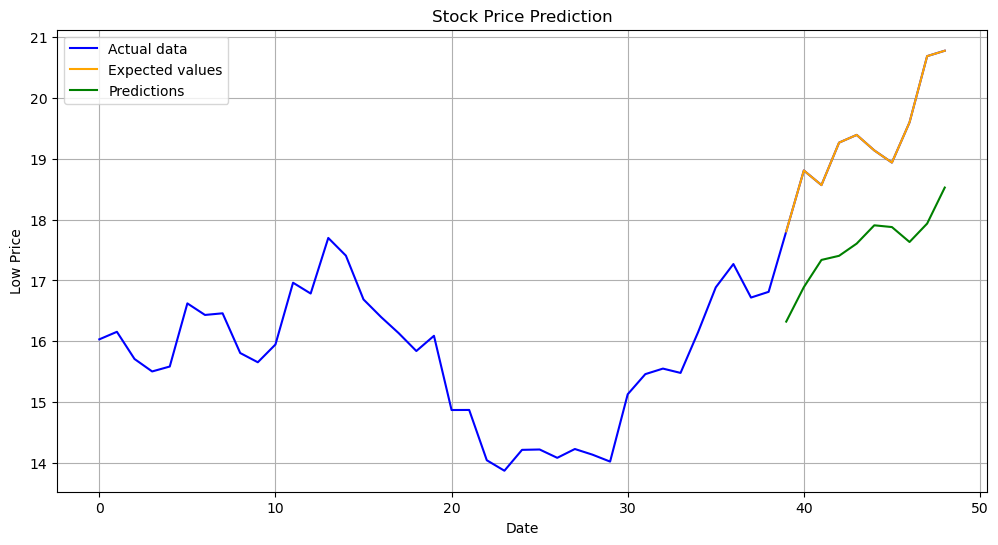

In [245]:
import matplotlib.pyplot as plt
# 训练集的实际值（Trained data）
y_train_actual = scaler_y.inverse_transform(y_train)  # 将训练集反归一化
y_test_actual = scaler_y.inverse_transform(y_test)  # 将测试集反归一化
y_pred = scaler_y.inverse_transform(model.predict(X_test))  # 测试集预测值反归一化


y_actual_combined = np.concatenate([y_train_actual, y_test_actual])
# 创建图表
plt.figure(figsize=(12, 6))

# 绘制训练集的实际值（蓝色）
plt.plot(
    range(len(y_actual_combined)),
    y_actual_combined,
    label='Actual data',
    color='blue'
)

# 绘制测试集的实际值（黄色），保持曲线连续
plt.plot(
    range(len(y_train_actual), len(y_actual_combined)),
    y_test_actual,
    label='Expected values',
    color='orange'
)

# 绘制测试集预测值（绿色）
plt.plot(
    range(len(y_train_actual), len(y_actual_combined)),
    y_pred,
    label='Predictions',
    color='green'
)

# 图表设置
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Low Price')
plt.legend()
plt.grid()
plt.show()


In [246]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test_actual, y_pred)
mse = mean_squared_error(y_test_actual, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test_actual, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 1.752588860553299
Mean Squared Error (MSE): 3.31423259507267
Root Mean Squared Error (RMSE): 1.8205033905688475
R-squared (R²): -3.500752947676725
